In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random
import gym 
import os
import time
import glob 
import import_ipynb

In [2]:
from utils_rf import DenseNet,play_and_record,compute_td_loss,ReplayBuffer

importing Jupyter notebook from utils_rf.ipynb


In [3]:
from tqdm import trange #progress bar
from IPython.display import clear_output
from scipy.signal import convolve, gaussian

In [4]:
MOMENTUM = 0.99
EPSILON = 1e-6

# Deep Q-learning

## Framework
To build the framework, we typically have the following goal:
$$
\begin{align}
J(\omega)=\mathbb{E}_{\pi}[(v_{\pi}-v_t(s))^2]
\end{align}
$$
Then by gradient descent, the following optimization procedure is in order: 
$$
\begin{align}
\omega_{t+1}=\omega_{t} + \alpha [v_{\pi}-v_t(s;\omega)] \nabla_{\omega} v_t(s;\omega)
\end{align}
$$

The analytic expression for $v_{\pi}$ is hard to attain, hence one typically resort to approximations. 
1. MC update: 
$$
\begin{align}
\omega_{t+1}=\omega_{t} + \alpha [G_{t}(s)-v_t(s;\omega)] \nabla_{\omega} v_t(s;\omega)
\end{align}
$$

2. TD(0) update: 
$$
\begin{align}
\omega_{t+1}=\omega_{t} + \alpha [R_{t+1}+\gamma v_t(s';\omega)-v_t(s;\omega)] \nabla_{\omega} v_t(s;\omega)
\end{align}
$$

### Batch DQN
Typically, one has a collection of information by doing simulations, and assume that in this case the target value function $v^{\pi}_n$, $n=1,...,T$ is known. The dataset takes the following form: 

$$D=\lbrace <s_1, v^{\pi}_1>,<s_2, v^{\pi}_2>,...,<s_T, v^{\pi}_T> \rbrace$$
Thus, in a batch mode under the assumption that the batch number is $N$, we have the following optimziation procedure. 

As a result, for the value function weight update, we have 
$$
\begin{align}
\omega_{t+1}=\omega_{t} + \frac{\alpha }{N} \sum^N_{i=1}[v_{\pi}(s_i)-\hat{v}(s_i;\omega)] \nabla_{\omega} \hat{v}(s_i;\omega)
\end{align}
$$
The same updating procedure can also be applied to the q-value functions:
$$
\begin{align}
\omega_{t+1}=\omega_{t} + \frac{\alpha }{N} \sum^N_{i=1}[q_{\pi}(s_i,a_i)-\hat{q}(s_i,a_i;\omega_t)] \nabla_{\omega} \hat{q}(s_i,a_i;\omega_t)
\end{align}
$$

One needs an approximation for the target function and it takes the following form: 
$$
q_{\pi} (s_i, a_i) = r_i + \gamma \max_{\tilde{a}_i} q (\tilde{s}_i, \tilde{a}_i;\omega^-_t)
$$
Some comments are in order:
1. The function $q$ is a different neural network function than the $\hat{q}$. 
2. The weights $\omega^-_t$ are not updated frequently, in fact, it is a history of the frequently updated weights: $\omega_t$ with some lag $L$. The goal is to keep the target function constant for a period instead of constantly chasing a moving target. 
3. Instead of updating the information in an online fashion, Replay buffer is used to facilitate the batch mode learning. 



The expected loss function is approximated by batch average. 
We will calculate average TD error per batch using the equation: 
$$
\begin{equation}
L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i)  \gamma   \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right]^2
\end{equation}
$$

In the loss above, the target function $r_i + \left( (1-done_i)  \gamma   \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right)$ is used for the approximation of true target function. The $done_i$ indicator specifies the if the state $s_i$ reaches the terminal state. 

$$ 
\DeclareMathOperator*{\max}{max} w_{t+1} \leftarrow w_t + \frac{\alpha }{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i)  \gamma  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$




## Variants

#### 1. Prioritized replay   
Weights are given to the samples in the Replay buffer. 

#### 2. Double Q-learning
This idea addresses the overestimation problem.
Originally, in the loss function 
$$r_i +  (1-done_i)  \gamma  \hat{q}(s_{i}^{'},\tilde{a}_i;w^{-}_{t}) $$where $\tilde{a}_i=\max_{a_i^{'}} \hat{q}(s_{i}^{'},a_i^{'};w^{-}_{t})$. 

For the new strategy 
$$r_i +  (1-done_i)  \gamma  \hat{q}(s_{i}^{'},\tilde{a}_i;w^{-}_{t}) $$where $\tilde{a}_i=\max_{a_i^{'}} \hat{q}(s_{i}^{'},a_i^{'};\boldsymbol{w_{t}})$. That is the $\tilde{a}_i$ is searched by using the parameter $\boldsymbol{w_{t}}$.

#### 3. Dueling DQN


# Code demon

#### Experience replay
The purpose of the experience replay is that it will transform the the algorithm from the online mode to the batch mode. 

## Setting up the environment

In [5]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

## Construct an agent

In [7]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

In [8]:
env_name = 'CartPole-v1'
env=make_env(env_name, seed=None)
state_shape = env.observation_space.shape
n_actions = env.action_space.n

In [9]:
class Config(object):
    state_dim=state_shape[0]
    num_hiddens=[state_dim,196,256,64,n_actions]
    Nlayers=len(num_hiddens)-1

In [10]:
cfg=Config()

In [11]:
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_dim, cfg, epsilon=0): 
        super(DQNAgent,self).__init__()
        self.epsilon=epsilon
        self.state_size =state_size 
        self.state_dim=self.state_size[0]
        self.action_dim=action_dim
        self.cfg=cfg
        
        self.network=DenseNet(cfg)
        self.parameters=self.network.parameters
    
    def forward(self, state_t):
        q_temp=self.network(state_t)
        return q_temp
    
    def get_qvalues(self,states):
        states=torch.tensor(states, device=device,dtype=torch.float32)
        
        qvalues=self.forward(states)
        return qvalues.data.cpu().numpy()
    
    ### Sample actions by using ϵ-greedy strategy
    def sample_actions(self, qvalues):
        batch_size, n_actions=qvalues.shape
        
        #randomly sample actions 
        random_actions=np.random.choice(n_actions,size=batch_size)
        optimal_actions=qvalues.argmax(axis=-1);
        
        ## 0--no random 1--random exploration
        explore=np.random.choice([0,1], batch_size, p=[1-self.epsilon, self.epsilon])
        
        #np.where:Return elements chosen from x or y depending on condition.
        #if explore ==0, pick optimal_action
        return np.where(explore,random_actions,optimal_actions)
        

In [12]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards=[]
    for _ in range(n_games):
        s=env.reset()
        reward=0
        for _ in range(t_max):
            qvalues=agent.get_qvalues([s])
            action=qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward+=r
            if done:
                break
                
        rewards.append(reward)
    return np.mean(rewards)

# Main code demo

In [13]:
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [14]:
env_name = 'CartPole-v1'
env=make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, cfg, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions, cfg, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

C:\Users\huisu\anaconda3\envs\gputest2\lib\site-packages\gym\core.py:201: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


<All keys matched successfully>

In [15]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

C:\Users\huisu\anaconda3\envs\gputest2\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)


10000


In [16]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 5 * 10**4

#init Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [17]:
mean_rw_history = []
td_loss_history = []

The loss function shows a lot of sporadic spikes, one can smooth it out with a Gaussian kernel.

buffer size = 10000, epsilon = 0.05000


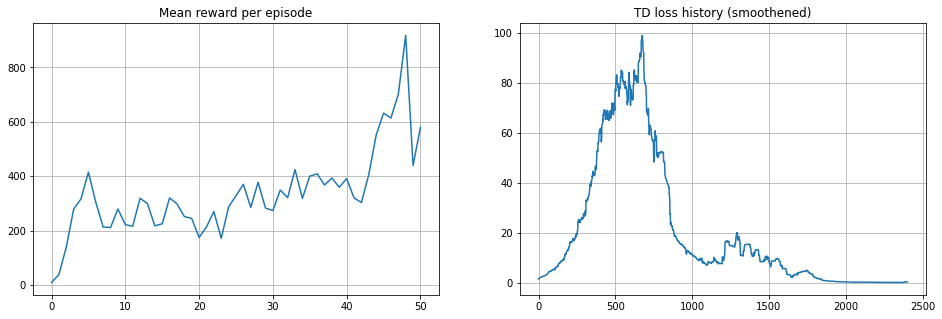

100%|███████████████████████████████████████████████████████████████████████████| 50001/50001 [02:29<00:00, 334.23it/s]


In [18]:
state = env.reset()

for step in trange(total_steps + 1):
    
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # upate the replay_buffer with the (sarsd) pairs 
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
    

    # loss = <compute TD loss>
    loss = compute_td_loss(agent, target_network, 
                           states, actions, rewards, next_states, done_flags,                  
                           gamma=0.99,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))#smoothen(td_loss_history)
        plt.grid()

        plt.show()

In [19]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: 583.1666666666666
Well done
